## Analisis Estadistico

### Descripción del proyecto
Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos. Más adelante, encontrarás en las instrucciones del proyecto cuáles son exactamente los aspectos del comportamiento de los clientes que debes analizar. Determinar qué plan, en promedio, aporta más ingresos es una cuestión que se abordará mediante pruebas estadísticas. Más adelante encontrarás más información al respecto en la sección de instrucciones del proyecto.

### Descripción de las tarifas
Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

A continuación puedes ver una descripción de las tarifas:

Surf
- Pago mensual: 20$.
- 500 minutos al mes, 50 SMS y 15 GB de datos.
- Si se exceden los límites del paquete:
- 1 minuto: 3 centavos.
- 1 SMS: 3 centavos.
- 1 GB de datos: 10$.

Ultimate

- Pago mensual: 70$.
- 3000 minutos al mes, 1000 SMS y 30 GB de datos.
- Si se exceden los límites del paquete:
- 1 minuto: 1 centavo.
- 1 SMS: 1 centavo.
- 1 GB de datos: 7$.


### Diccionario de Datos

La tabla users (datos sobre los usuarios):
 
* user_id: identificador único del usuario.
* first_name: nombre del usuario.
* last_name: apellido del usuario.
* age: edad del usuario (en años).
* reg_date: fecha de suscripción (dd, mm, aa).
* churn_date: la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).
* city: ciudad de residencia del usuario.
* plan: nombre de la tarifa.

La tabla calls (datos sobre las llamadas):
 
* id: identificador único de la llamada.
* call_date: fecha de la llamada.
* duration: duración de la llamada (en minutos).
* user_id: el identificador del usuario que realiza la llamada.

La tabla messages (datos sobre los SMS):
 
* id: identificador único del SMS.
* message_date: fecha del SMS.
* user_id: el identificador del usuario que manda el SMS.

La tabla internet (datos sobre las sesiones web):
 
* id: identificador único de la sesión.
* mb_used: el volumen de datos gastados durante la sesión (en megabytes).
* session_date: fecha de la sesión web.
* user_id: identificador del usuario.

La tabla plans (datos sobre las tarifas):
 
* plan_name: nombre de la tarifa.
* usd_monthly_fee: pago mensual en dólares estadounidenses.
* minutes_included: minutos incluidos al mes.
* messages_included: SMS incluidos al mes.
* mb_per_month_included: datos incluidos al mes (en megabytes).
* usd_per_minute: precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos, el operador cobrará el minuto 101).
* usd_per_message: precio por SMS tras exceder los límites del paquete.
* usd_per_gb: precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes).

In [1]:
# Cargamod todas las librerías
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
# Carga los archivos de datos en diferentes DataFrames

raw_calls = pd.read_csv("../raw/megaline_calls.csv")
raw_internet=pd.read_csv("../raw/megaline_internet.csv")
raw_messages=pd.read_csv("../raw/megaline_messages.csv")
raw_plans=pd.read_csv("../raw/megaline_plans.csv")
raw_users=pd.read_csv("../raw/megaline_users.csv")


### Exploramos Tarifas de raw_plans

In [3]:
raw_plans.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
#Vemos los datos en plans ya que son pocos registros
raw_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [5]:
raw_plans.rename(columns={'plan_name':'plan_id'}, inplace=True)
raw_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_id
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


### raw_plans
1. No encontramos ningun Dato faltante.<br/>
2. Todas los tipos de datos son adecuados.<br/>
3. Solo tiene 2 registros, correspondientes a 2 planes establecidos.

In [6]:
raw_users.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
#  Revisamos si hay duplicados
raw_calls.duplicated().value_counts()

False    137735
Name: count, dtype: int64

In [8]:
# Muestra de registros aleatoria
raw_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
237,1237,Leighann,Wheeler,50,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-08-26,ultimate,NaN
435,1435,Darnell,Powell,23,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-07-24,ultimate,NaN
177,1177,Seymour,Anderson,33,"Seattle-Tacoma-Bellevue, WA MSA",2018-11-09,surf,NaN
460,1460,Winford,Underwood,46,"Fresno, CA MSA",2018-05-28,ultimate,NaN
449,1449,Boyd,Kelley,39,"Seattle-Tacoma-Bellevue, WA MSA",2018-10-04,surf,NaN
220,1220,Jack,Strong,26,"Cincinnati, OH-KY-IN MSA",2018-04-22,surf,2018-10-13
149,1149,Jamaal,Camacho,54,"San Francisco-Oakland-Berkeley, CA MSA",2018-03-03,surf,NaN
369,1369,Bernard,Mckee,69,"Milwaukee-Waukesha, WI MSA",2018-10-06,surf,NaN
99,1099,Shavon,Banks,48,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-26,surf,NaN
131,1131,Shane,Morrison,60,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-01-07,surf,NaN


In [9]:
# Actualizamos tipos de datos y renombramos columna
raw_users['reg_date']=pd.to_datetime(raw_users['reg_date'],format='%Y-%m-%d')
raw_users['churn_date']=pd.to_datetime(raw_users['churn_date'],format='%Y-%m-%d')
raw_users.rename(columns={'plan':'plan_id'}, inplace=True)

raw_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_id     500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [10]:
## Enriquecimiento de datos
raw_users['status'] = ["Active" if reg else "Cancelled" for reg in raw_users['churn_date'].isna()]

n=0
raw_users['code_city']=""

for row in raw_users.itertuples():
    raw_users.loc[n,'city'],raw_users.loc[n,'code_city'] = row.city.split(",")
    n+=1
    
raw_users.sample(20)

,user_id,first_name,last_name,age,city,reg_date,plan_id,churn_date,status,code_city
240,1240,Drema,Lopez,61,Baton Rouge,2018-03-18,surf,NaT,Active,LA MSA
192,1192,Korey,Goodwin,36,Buffalo-Cheektowaga,2018-10-02,surf,NaT,Active,NY MSA
329,1329,Doyle,Nunez,65,Charleston-North Charleston,2018-08-25,ultimate,NaT,Active,SC MSA
0,1000,Anamaria,Bauer,45,Atlanta-Sandy Springs-Roswell,2018-12-24,ultimate,NaT,Active,GA MSA
94,1094,Walter,Petersen,54,Los Angeles-Long Beach-Anaheim,2018-10-30,surf,2018-12-12,Cancelled,CA MSA
121,1121,Kathaleen,Albert,34,Miami-Fort Lauderdale-West Palm Beach,2018-03-13,surf,NaT,Active,FL MSA
303,1303,Rosamaria,Reeves,67,Detroit-Warren-Dearborn,2018-10-25,ultimate,NaT,Active,MI MSA
238,1238,Jackeline,Byrd,42,Dallas-Fort Worth-Arlington,2018-06-16,surf,NaT,Active,TX MSA
285,1285,Joesph,Barry,28,Los Angeles-Long Beach-Anaheim,2018-08-03,surf,NaT,Active,CA MSA
401,1401,Charmain,Bryant,67,Richmond,2018-08-24,ultimate,NaT,Active,VA MSA


In [11]:
#Actualizamos los valores NaN a una fecha ficticia.
raw_users['churn_date'] = raw_users['churn_date'].fillna(pd.Timestamp('2099-12-31'))

raw_users.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_id     500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
 8   status      500 non-null    object        
 9   code_city   500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 39.2+ KB


### raw_users
1. Imputamos los datos faltanes.<br/>
2. Todas los tipos de datos son adecuados.<br/>
3. Dividimos la columna 'city' en ciudad y su codigo de ciudad.
4. Creamos la columna 'status'

In [12]:
### Llamadas
raw_calls.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
raw_calls.duplicated().value_counts()

False    137735
Name: count, dtype: int64

In [14]:
raw_calls['call_date'] = pd.to_datetime(raw_calls['call_date'],format='%Y-%m-%d')
df_calls = raw_calls.rename(columns={'id':'calls_id'})

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   calls_id   137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [15]:
# Realizamos redondeo hacia arriba, para respetar el proceso de calculo

raw_calls['duration_minute'] = np.ceil(raw_calls['duration']) 
raw_calls

,id,user_id,call_date,duration,duration_minute
0,1000_93,1000,2018-12-27,8.52,9.0
1,1000_145,1000,2018-12-27,13.66,14.0
2,1000_247,1000,2018-12-27,14.48,15.0
3,1000_309,1000,2018-12-28,5.76,6.0
4,1000_380,1000,2018-12-30,4.22,5.0
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,9.0
137731,1499_200,1499,2018-10-20,10.89,11.0
137732,1499_201,1499,2018-09-21,8.12,9.0
137733,1499_202,1499,2018-10-10,0.37,1.0


In [16]:
# Muestra de calls
raw_calls.sample(10)

,id,user_id,call_date,duration,duration_minute
20268,1077_235,1077,2018-07-13,4.29,5.0
114861,1402_107,1402,2018-10-13,8.39,9.0
8283,1039_223,1039,2018-08-31,4.13,5.0
132371,1476_320,1476,2018-08-07,0.00,0.0
79763,1285_256,1285,2018-09-15,23.93,24.0
85099,1313_79,1313,2018-07-01,0.00,0.0
55609,1199_236,1199,2018-09-01,4.54,5.0
45866,1166_49,1166,2018-10-25,15.35,16.0
90114,1327_39,1327,2018-09-21,3.03,4.0
608,1004_76,1004,2018-08-14,4.02,5.0


### raw_calls
1. No encontramos ningun dato faltante.
2. Convertimos 'call_date' a tipo datetime
3. Actualizamos la columna 'id' a 'calls_id'
4. Redondeamos la cantidad de minutos en duration_time 


In [17]:
raw_messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [18]:
#Verificamos si hay duplicados
raw_messages.duplicated().value_counts()

False    76051
Name: count, dtype: int64

In [19]:
raw_messages['message_date'] = pd.to_datetime(raw_messages['message_date'])
raw_messages = raw_messages.rename(columns={'id':'message_id'})

raw_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   message_id    76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [20]:
raw_messages.sample(10)

,message_id,user_id,message_date
7224,1059_95,1059,2018-05-19
66706,1434_240,1434,2018-10-04
776,1007_78,1007,2018-08-29
38930,1254_689,1254,2018-08-26
59334,1374_508,1374,2018-05-18
40390,1261_16,1261,2018-06-22
64631,1412_213,1412,2018-08-03
62399,1392_174,1392,2018-11-04
15057,1101_114,1101,2018-06-06
29841,1183_236,1183,2018-11-04


### raw_messages
1. No encontramos ningun Dato faltante, ni duplicados.<br/>
2. Tenemos una columna que almacena datos de fecha que deberia ser tipo datetime<br/>
3. Cambiaremos la columna 'id' por 'message_id' para tenerlo claro a la hora de los merges ya que otros dataframe tiene el mismo campo.

In [21]:
raw_internet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [22]:
#Verificamos si hay duplicados
raw_internet.duplicated().value_counts()

False    104825
Name: count, dtype: int64

In [23]:
raw_internet = raw_internet.rename(columns={'id':'internet_id'})
raw_internet['session_date'] = pd.to_datetime(raw_internet['session_date'],format='%Y-%m-%d')

raw_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   internet_id   104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [24]:
raw_internet['gb_used']=np.ceil(raw_internet['mb_used']/1024)

raw_internet

,internet_id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,1.0
1,1000_204,1000,2018-12-31,0.00,0.0
2,1000_379,1000,2018-12-28,660.40,1.0
3,1000_413,1000,2018-12-26,270.99,1.0
4,1000_442,1000,2018-12-27,880.22,1.0
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,1.0
104821,1499_216,1499,2018-12-30,304.72,1.0
104822,1499_217,1499,2018-09-22,292.75,1.0
104823,1499_218,1499,2018-12-07,0.00,0.0


In [25]:
raw_internet.sample(10)

,internet_id,user_id,session_date,mb_used,gb_used
74852,1353_15,1353,2018-09-22,0.00,0.0
3930,1022_341,1022,2018-07-01,518.89,1.0
64597,1296_132,1296,2018-12-30,259.74,1.0
42275,1187_452,1187,2018-12-17,441.51,1.0
72898,1339_35,1339,2018-11-16,465.49,1.0
27342,1126_497,1126,2018-09-13,80.89,1.0
66813,1312_36,1312,2018-08-29,0.00,0.0
52378,1236_229,1236,2018-04-05,662.01,1.0
31956,1145_92,1145,2018-06-12,209.65,1.0
33264,1151_6,1151,2018-11-23,723.47,1.0


### raw_internet
1. No encontramos ningun dato faltante, ni duplicados.
2. Tenemos una columna que almacena datos de fecha que deberia ser tipo datetime.
3. Cambiaremos la columna 'id' por 'internet_id' para tenerlo claro a la hora de los merges ya que otros dataframe tiene el mismo campo.
4. Creamos la columna 'gb_used' tomando los 'mb_used' pasandolo de megabyte a gigabyte, redondeando hacia arriba.

### Resumen

In [26]:
df_calls = raw_calls
df_internet = raw_internet
df_messages = raw_messages
df_plans = raw_plans
df_users = raw_users

#### Estudiaremos las condiciones de las tarifas

In [27]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_id
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [28]:
# Calculamos el número de llamadas hechas por cada usuario al mes. Guarda el resultadoel resultado.

df_user_calls = df_calls.merge(df_users, on='user_id', how='left')
df_user_calls

calls_user = df_user_calls.pivot_table(index=['user_id', df_user_calls['call_date'].dt.month],
                            values=['duration'],
                            aggfunc=['count']).reset_index()
calls_user

,user_id,call_date,count
,,,duration
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53


In [29]:
# Calculamos la cantidad de minutos usados por cada usuario al mes. Guardamos el resultado.

minutes_used = df_user_calls.groupby(['user_id',df_user_calls['call_date'].dt.month])['duration_minute'].sum()
minutes_used

user_id  call_date
1000     12           124.0
1001     8            182.0
         9            315.0
         10           393.0
         11           426.0
                      ...  
1498     12           339.0
1499     9            346.0
         10           385.0
         11           308.0
         12           496.0
Name: duration_minute, Length: 2258, dtype: float64

In [30]:
# Calculamos el número de mensajes enviados por cada usuario al mes. Guardamos el resultado.
df_user_messages = df_users.merge(df_messages, on='user_id',how='left')

messages_user = df_user_messages.groupby(['user_id',df_user_messages['message_date'].dt.month])['message_id'].count()
messages_user

user_id  message_date
1000     12.0            11
1001     8.0             30
         9.0             44
         10.0            53
         11.0            36
                         ..
1496     9.0             21
         10.0            18
         11.0            13
         12.0            11
1497     12.0            50
Name: message_id, Length: 1806, dtype: int64

In [31]:
# Calculamos el volumen del tráfico de Internet usado por cada usuario al mes. Guardamos el resultado.
df_users_internet = df_users.merge(df_internet, on='user_id',how='left')

internet_user = df_users_internet.groupby(['user_id',df_users_internet['session_date'].dt.month])['gb_used'].sum()
internet_user

user_id  session_date
1000     12.0             4.0
1001     8.0             21.0
         9.0             41.0
         10.0            50.0
         11.0            49.0
                         ... 
1498     12.0            56.0
1499     9.0             37.0
         10.0            52.0
         11.0            43.0
         12.0            58.0
Name: gb_used, Length: 2277, dtype: float64

In [32]:
# Fusionamos los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
df_concat = pd.concat([minutes_used,messages_user,internet_user], axis='columns')
df_concat.columns=['minutes_user','messages_user','internet_user']

df_concat

minutes_user  messages_user  internet_user
user_id                                                 
1000    12.0         124.0           11.0            4.0
1001    8.0          182.0           30.0           21.0
        9.0          315.0           44.0           41.0
        10.0         393.0           53.0           50.0
        11.0         426.0           36.0           49.0
...                    ...            ...            ...
1349    12.0           NaN           61.0           27.0
1361    5.0            NaN            2.0            7.0
1482    10.0           NaN            2.0            NaN
1108    12.0           NaN            NaN            2.0
1311    6.0            NaN            NaN            7.0

[2293 rows x 3 columns]

In [33]:
df_concat = df_concat.reset_index()
df_concat

,user_id,level_1,minutes_user,messages_user,internet_user
0,1000,12.0,124.0,11.0,4.0
1,1001,8.0,182.0,30.0,21.0
2,1001,9.0,315.0,44.0,41.0
3,1001,10.0,393.0,53.0,50.0
4,1001,11.0,426.0,36.0,49.0
...,...,...,...,...,...
2288,1349,12.0,NaN,61.0,27.0
2289,1361,5.0,NaN,2.0,7.0
2290,1482,10.0,NaN,2.0,NaN
2291,1108,12.0,NaN,NaN,2.0


In [34]:
# Añade la información de la tarifa

df_plans_user = df_users.merge(df_plans, on='plan_id', how='left')
df_plans_user

,user_id,first_name,last_name,age,city,reg_date,plan_id,churn_date,status,code_city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,Anamaria,Bauer,45,Atlanta-Sandy Springs-Roswell,2018-12-24,ultimate,2099-12-31,Active,GA MSA,1000,30720,3000,70,7,0.01,0.01
1,1001,Mickey,Wilkerson,28,Seattle-Tacoma-Bellevue,2018-08-13,surf,2099-12-31,Active,WA MSA,50,15360,500,20,10,0.03,0.03
2,1002,Carlee,Hoffman,36,Las Vegas-Henderson-Paradise,2018-10-21,surf,2099-12-31,Active,NV MSA,50,15360,500,20,10,0.03,0.03
3,1003,Reynaldo,Jenkins,52,Tulsa,2018-01-28,surf,2099-12-31,Active,OK MSA,50,15360,500,20,10,0.03,0.03
4,1004,Leonila,Thompson,40,Seattle-Tacoma-Bellevue,2018-05-23,surf,2099-12-31,Active,WA MSA,50,15360,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,New York-Newark-Jersey City,2018-09-04,surf,2099-12-31,Active,NY-NJ-PA MSA,50,15360,500,20,10,0.03,0.03
496,1496,Ariel,Shepherd,49,New Orleans-Metairie,2018-02-20,surf,2099-12-31,Active,LA MSA,50,15360,500,20,10,0.03,0.03
497,1497,Donte,Barrera,49,Los Angeles-Long Beach-Anaheim,2018-12-10,ultimate,2099-12-31,Active,CA MSA,1000,30720,3000,70,7,0.01,0.01
498,1498,Scot,Williamson,51,New York-Newark-Jersey City,2018-02-04,surf,2099-12-31,Active,NY-NJ-PA MSA,50,15360,500,20,10,0.03,0.03


In [35]:
# Calcula el ingreso mensual para cada usuario
def data_calculate(user): # funcion para tomar los datos del costo segun el plan
    
    for row in df_plans_user.itertuples():
        if user == row.user_id:
            data = {}
            data['messages_included'] = row.messages_included
            data['mb_per_month_included'] = row.mb_per_month_included
            data['minutes_included'] = row.minutes_included
            data['usd_monthly_pay'] = row.usd_monthly_pay
            data['usd_per_gb'] = row.usd_per_gb
            data['usd_per_message'] = row.usd_per_message
            data['usd_per_minute'] = row.usd_per_minute
            break
            
    return data
#
#

n = 0
df_concat["total"] = ""
for row in df_concat.itertuples():
    total = 0
    costs = data_calculate(row.user_id)  # Costs tiene los datos limites de datos y costos adicionales
    total = costs['usd_monthly_pay']
    
    if (row.minutes_user - costs['minutes_included']) > 0: # costo de llamadas
        total += (row.minutes_user - costs['minutes_included']) * costs['usd_per_minute'] # adicional por exceso de minutos
    
    if (row.messages_user - costs['messages_included']) > 0: # costo de mensajes
        total += (row.messages_user - costs['messages_included']) * costs['usd_per_message'] # adicional por exceso de mensajes
    
    if (row.internet_user - costs['mb_per_month_included']/1024) > 0:
        total += (row.internet_user - costs['mb_per_month_included']/1024) * costs['usd_per_gb'] # adicional por exceso de gigabyte
    df_concat.loc[n,'total']=round(total,2)
    
    n+=1
    
df_concat

,user_id,level_1,minutes_user,messages_user,internet_user,total
0,1000,12.0,124.0,11.0,4.0,70
1,1001,8.0,182.0,30.0,21.0,80.0
2,1001,9.0,315.0,44.0,41.0,280.0
3,1001,10.0,393.0,53.0,50.0,370.09
4,1001,11.0,426.0,36.0,49.0,360.0
...,...,...,...,...,...,...
2288,1349,12.0,NaN,61.0,27.0,140.33
2289,1361,5.0,NaN,2.0,7.0,20
2290,1482,10.0,NaN,2.0,NaN,70
2291,1108,12.0,NaN,NaN,2.0,70


#### Estudiaremos los comportamientos de los usuarios

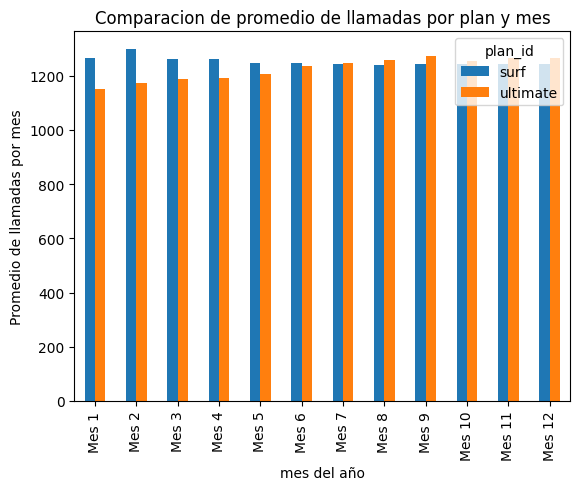

In [36]:
# Comparamos la duración promedio de llamadas por cada plan y por cada mes. Trazamos un gráfico de barras para visualizarla.
df_user_calls_plan = df_user_calls.merge(df_plans, on='plan_id', how='left')

pivot_data = df_user_calls_plan.pivot_table(index='plan_id', columns=df_user_calls_plan['call_date'].dt.month, values='user_id',aggfunc='mean')
pivot_data
pivot_data.columns = [f'Mes {col}' for col in pivot_data.columns]
ax = pivot_data.T.plot(kind='bar', ylabel='Promedio de llamadas por mes',xlabel='mes del año',title='Comparacion de promedio de llamadas por plan y mes')

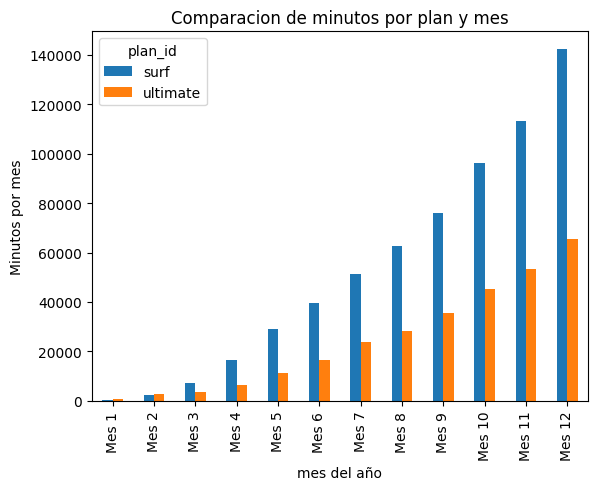

In [37]:
# Comparamos el número de minutos mensuales que necesitan los usuarios de cada plan. Trazamos un histograma.

pivot_data2 = df_user_calls_plan.pivot_table(index='plan_id', columns=df_user_calls_plan['call_date'].dt.month, values='duration',aggfunc='sum')
pivot_data2.columns = [f'Mes {col}' for col in pivot_data2.columns]

ax = pivot_data2.T.plot(kind='bar', ylabel='Minutos por mes',xlabel='mes del año',title='Comparacion de minutos por plan y mes')

In [38]:
# Calculamos la media y la varianza de la duración mensual de llamadas.

df_calls_media_var = df_user_calls_plan.groupby(['plan_id',df_user_calls_plan['call_date'].dt.month])

df_calls_media_var.agg(duration_mean=('duration_minute','mean'),duration_var=('duration','var'))

duration_mean  duration_var
plan_id  call_date                             
surf     1               6.766667     28.208311
         2               7.303279     35.218169
         3               7.106742     32.393177
         4               7.191899     33.406473
         5               7.173700     34.617366
         6               7.251863     35.141490
         7               7.124836     33.461154
         8               7.124718     33.951388
         9               7.128537     34.649189
         10              7.120604     33.793825
         11              7.160421     33.726179
         12              7.239358     34.649544
ultimate 1               6.910714     35.442188
         2               6.916667     33.688628
         3               6.614130     32.882171
         4               7.088176     32.071262
         5               7.054491     34.371065
         6               7.110522     33.435551
         7               7.276061     34.567847
         8               7.015709     33.681555
         9               7.166857     34.019359
         10              7.066706     34.206399
         11              7.138889     34.741937
         12              7.073878     33.363816

<Axes: ylabel='duration_minute'>

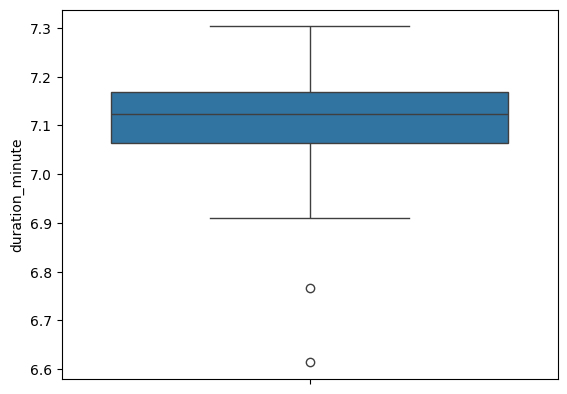

In [39]:
# Trazamos un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

df_duration_calls = df_user_calls_plan.groupby(['plan_id',df_user_calls_plan['call_date'].dt.month])['duration_minute'].mean()
sns.boxplot(df_duration_calls)


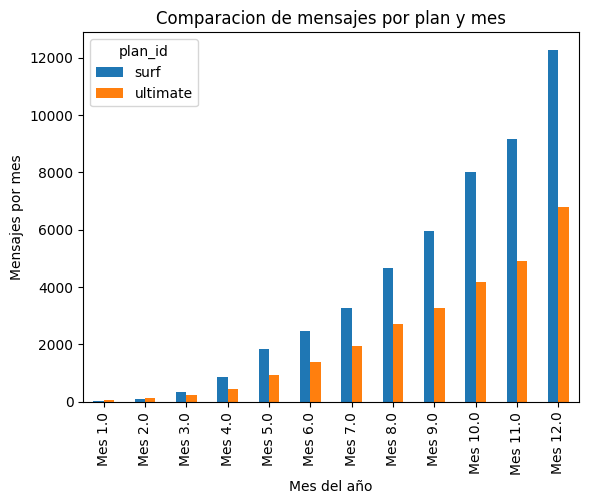

In [40]:
# Compraramos el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
pivot_data3 = df_user_messages.pivot_table(index='plan_id', columns=df_user_messages['message_date'].dt.month, values='user_id',aggfunc='count')
pivot_data3.columns = [f'Mes {col}' for col in pivot_data3.columns]
 
ax = pivot_data3.T.plot(kind='bar', ylabel='Mensajes por mes',xlabel='Mes del año',title='Comparacion de mensajes por plan y mes')

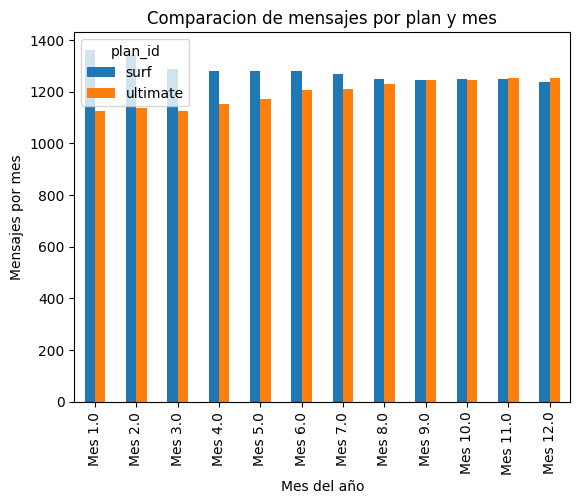

In [41]:
# Compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.
pivot_data4 = df_user_messages.pivot_table(index='plan_id', columns=df_user_messages['message_date'].dt.month, values='user_id',aggfunc='mean')
pivot_data4.columns = [f'Mes {col}' for col in pivot_data4.columns]
ax = pivot_data4.T.plot(kind='bar', ylabel='Mensajes por mes',xlabel='Mes del año',title='Comparacion de mensajes por plan y mes')

In [42]:
# Comparamos la cantidad de tráfico de Internet consumido por usuarios por plan
df_users_internet.groupby(['plan_id','user_id'])['mb_used'].sum().reset_index()

,plan_id,user_id,mb_used
0,surf,1001,80437.94
1,surf,1002,40293.33
2,surf,1003,27044.14
3,surf,1004,156352.81
4,surf,1005,17140.17
...,...,...,...
495,ultimate,1482,20806.13
496,ultimate,1487,13992.39
497,ultimate,1490,190904.51
498,ultimate,1493,76378.43


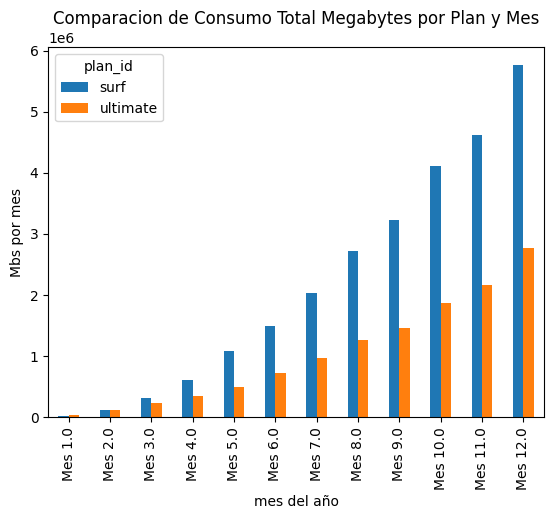

In [43]:
#Comparamos los megabytes para cada plan
pivot_data5=df_users_internet.pivot_table(index='plan_id', columns=df_users_internet['session_date'].dt.month,values='mb_used',aggfunc='sum')
pivot_data5.columns = [f'Mes {col}' for col in pivot_data5.columns]
 
ax = pivot_data5.T.plot(kind='bar', ylabel='Mbs por mes',xlabel='mes del año',title='Comparacion de Consumo Total Megabytes por Plan y Mes')

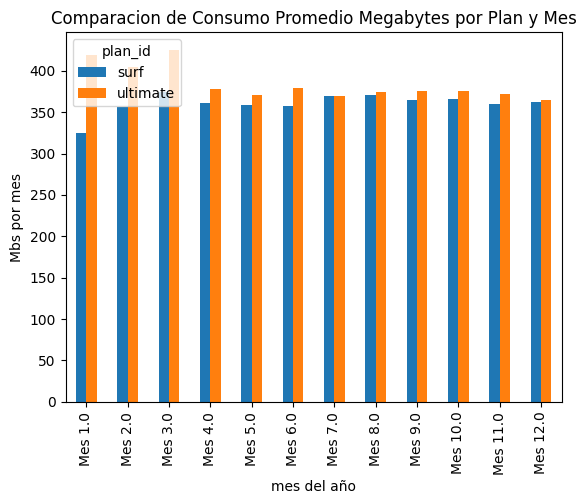

In [44]:
# Comparamos consumo de internet

pivot_data6=df_users_internet.pivot_table(index='plan_id', columns=df_users_internet['session_date'].dt.month,values='mb_used',aggfunc='mean')
pivot_data6.columns = [f'Mes {col}' for col in pivot_data6.columns]
 
ax = pivot_data6.T.plot(kind='bar', ylabel='Mbs por mes',xlabel='mes del año',title='Comparacion de Consumo Promedio Megabytes por Plan y Mes')

### Ingresos

In [45]:
df_tarifas = df_concat.merge(df_plans_user[['user_id','plan_id']], how='left', on='user_id')
df_tarifas

,user_id,level_1,minutes_user,messages_user,internet_user,total,plan_id
0,1000,12.0,124.0,11.0,4.0,70,ultimate
1,1001,8.0,182.0,30.0,21.0,80.0,surf
2,1001,9.0,315.0,44.0,41.0,280.0,surf
3,1001,10.0,393.0,53.0,50.0,370.09,surf
4,1001,11.0,426.0,36.0,49.0,360.0,surf
...,...,...,...,...,...,...,...
2288,1349,12.0,NaN,61.0,27.0,140.33,surf
2289,1361,5.0,NaN,2.0,7.0,20,surf
2290,1482,10.0,NaN,2.0,NaN,70,ultimate
2291,1108,12.0,NaN,NaN,2.0,70,ultimate


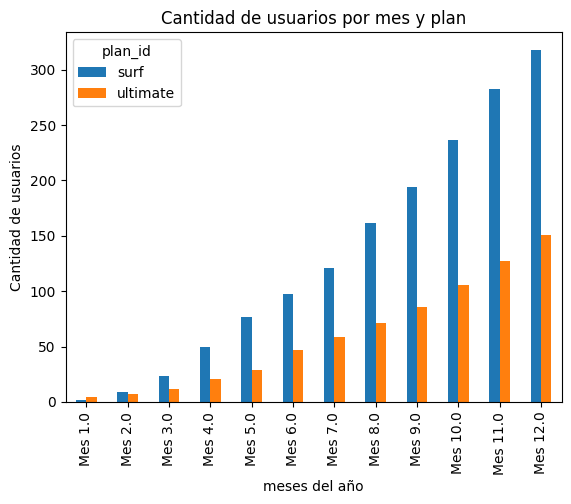

In [46]:
#Comparamos cantidad de usuarios por mes y plan

pivot_in = df_tarifas.pivot_table(index='plan_id', columns='level_1', values='total', aggfunc='count')
pivot_in.columns = [f'Mes {col}' for col in pivot_in.columns]

pivot_in.T.plot(kind='bar', xlabel='meses del año', ylabel='Cantidad de usuarios', title ='Cantidad de usuarios por mes y plan')

plt.show()

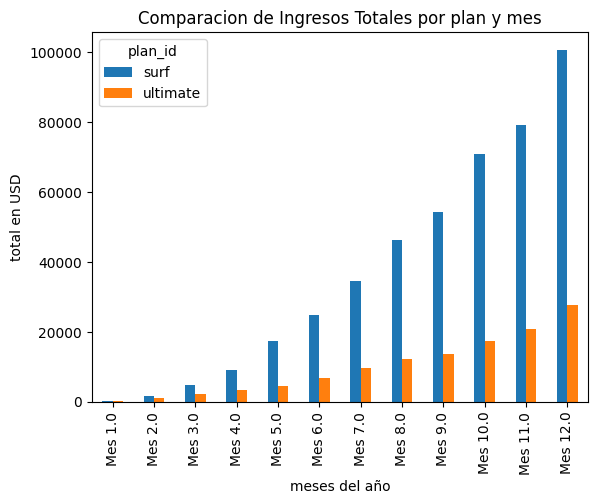

In [47]:
#Comparacion de Ingresos Totales por plan y mes

pivot_in = df_tarifas.pivot_table(index='plan_id', columns='level_1', values='total', aggfunc='sum')
pivot_in.columns = [f'Mes {col}' for col in pivot_in.columns]

pivot_in.T.plot(kind='bar', xlabel='meses del año', ylabel='total en USD', title ='Comparacion de Ingresos Totales por plan y mes')

plt.show()

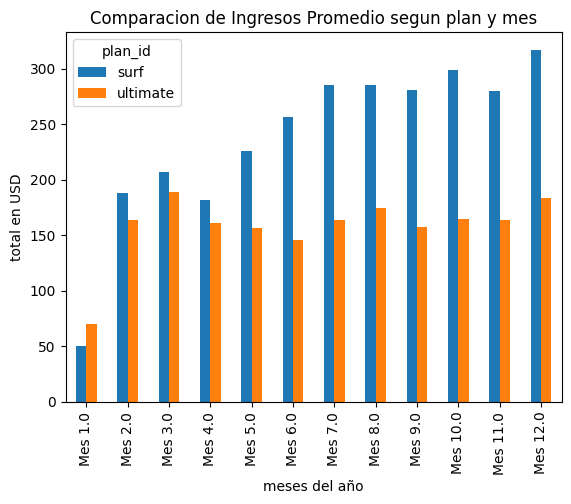

In [48]:
# Comparacion de Ingresos Promedio segun plan y mes

pivot_in = df_tarifas.pivot_table(index='plan_id', columns='level_1', values='total', aggfunc='mean')
pivot_in.columns = [f'Mes {col}' for col in pivot_in.columns]

pivot_in.T.plot(kind='bar', xlabel='meses del año', ylabel='total en USD', title ='Comparacion de Ingresos Promedio segun plan y mes',)
plt.show()

## Hallasgos
### Llamadas
1. Podemos ver que la cantidad de llamadas al mes es muy similar en ambos planes.
2. Podemos ver que la cantidad de minutos va en incremento de enero a diciembre pero hay una gran diferencia entre los planes surf y ultimate, los ultimate consumen muchos mas minutos que los de plan surf.
3. Excepto en el mes de Enero y Febrero donde los del plan surf usan mas minutos que los plan ultimate, podriamos plantear la hipotesis que esto sea por temas de vacaciones. 

### Mensajes
1. Podemos ver que los mensajes tiene un comportamiento similar a las llamadas en cantidad.
2. Podemos ver en promedio mensajes de los que tienen plan surf va en incremento hasta diciembre, en cambio para los del plan ultimate estos van reduciendo hasta igualar a los del plan Surf.
3. Podemos ver que en Enero y Febrero los que tiene plan ultimate tienen un incremento interesante frente a los otros meses esto podria deberse a las vacaciones donde no atienden muchas llamadas.
4. Los del plan Surf tambien se reducen de Enero a Marzo, correspondiente a las vacaciones de temporada.

### Internet
1. Podemos ver que los megavytes usados por los usuarios van en incremento de enero a diciembre para ambos planes siendo el ultime mayor en todo momento.
2. Pero vemos que en promedio los del plan ultimate de Enero a Marzo tienen un consumo superior al promedio y luego varia pero nunca supera a los primeros meses.
3. Pero vemos que en promedio los del plan surf en Enero es el mes de consumo mas bajo en promedio luego sube y se mantiene ondulante, en los meses de Julio y Agosto el consumo es practicamente igual al del plan ultimate

### Ingresos
1. A simple vista vemos que el paquete 'Ultimate' presenta el mayor consumo en general en todos los servicios y porsupuesto en cantidad de ingresos.
2. La cantidad de usuarios por mes y plan se va incrementando a medida que pasan los mes los de plan ultimate se incrementan a un ritmo casi exponencial y los del plan surf se incrementan a un ritmo mas lineal.
3. Para los totales generados para cada mes y plan tenemos un crecimiento exponencial en ambos casos.
4. La comparacion de ingresos promedio vemos que ultimate se mantiene entre 70 y 75 dolares todos los meses del año en cambio e los del plan surf un incremento con altibajos desde enero con 20 dolares hasta diciembre que alcanza los 70 dolares, tambien vemos que los meses Julio, Agosto y Octubre tenemos ingresos promedio de 60 solares.

### Prueba las hipótesis estadísticas

In [49]:
# Prueba las hipótesis
surf=pd.Series(df_tarifas[df_tarifas['plan_id']=='surf']['total']) #Tomamos la serie de totales para el plan Surf
surf = pd.to_numeric(surf, errors='coerce')

ultimate=pd.Series(df_tarifas[df_tarifas['plan_id']=='ultimate']['total']) #Tomamos la serie de totales para el plan Ultimate
ultimate = pd.to_numeric(ultimate, errors='coerce')

print(surf)
print(surf.dtypes)

print(ultimate)
print(ultimate.dtypes)

 # obtenemos serias de ambas muestras

1        80.00
2       280.00
3       370.09
4       360.00
5       420.00
         ...  
2282    510.18
2286    140.78
2287    210.66
2288    140.33
2289     20.00
Name: total, Length: 1573, dtype: float64
float64
0        70
19       70
20      294
26      196
27      252
       ... 
2284    406
2285     70
2290     70
2291     70
2292     70
Name: total, Length: 720, dtype: int64
int64


In [50]:
# Nivel de significación estadística
alpha = 0.05  # Usualmente se utiliza 0.05 para un nivel estándar

# Realizar la prueba t
results = st.ttest_ind(surf, ultimate, equal_var=False)

# Imprimir el valor p
print(f"Valor p: {results.pvalue:.2e}")

# Comparar el valor p con el nivel de significación
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: las medias son significativamente diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: las medias no son significativamente diferentes.")


Valor p: 2.32e-97
Rechazamos la hipótesis nula: las medias son significativamente diferentes.


In [51]:
# Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

df_tarifas_code= df_tarifas.merge(df_users[['user_id','code_city']], on='user_id',how='left')
df_tarifas_code

,user_id,level_1,minutes_user,messages_user,internet_user,total,plan_id,code_city
0,1000,12.0,124.0,11.0,4.0,70,ultimate,GA MSA
1,1001,8.0,182.0,30.0,21.0,80.0,surf,WA MSA
2,1001,9.0,315.0,44.0,41.0,280.0,surf,WA MSA
3,1001,10.0,393.0,53.0,50.0,370.09,surf,WA MSA
4,1001,11.0,426.0,36.0,49.0,360.0,surf,WA MSA
...,...,...,...,...,...,...,...,...
2288,1349,12.0,NaN,61.0,27.0,140.33,surf,MA-NH MSA
2289,1361,5.0,NaN,2.0,7.0,20,surf,AL MSA
2290,1482,10.0,NaN,2.0,NaN,70,ultimate,NY-NJ-PA MSA
2291,1108,12.0,NaN,NaN,2.0,70,ultimate,UT MSA


In [52]:
with_NY_NJ = df_tarifas_code[df_tarifas_code['code_city'].str.contains("NY-NJ", case=False)]['total']
with_NY_NJ = pd.to_numeric(with_NY_NJ, errors='coerce')

without_NY_NJ = df_tarifas_code[~df_tarifas_code['code_city'].str.contains("NY-NJ", case=False)]['total']
without_NY_NJ = pd.to_numeric(without_NY_NJ, errors='coerce')

print("Promedio del Area NY-NJ:",with_NY_NJ.mean().round(2))
print("Promedio del Fuera del Area NY-NJ:",without_NY_NJ.mean().round(2))

Promedio del Area NY-NJ: 265.58
Promedio del Fuera del Area NY-NJ: 241.97


In [53]:
# Prueba las hipótesis

alpha = 0.05

results= st.ttest_ind(with_NY_NJ,without_NY_NJ,equal_var=False)

print('valor p:', results.pvalue)# tu código: imprime el valor p obtenido)

if (results.pvalue < alpha):# su código: compara los valores p obtenidos con el nivel de significación estadística):
    print("Rechazamos la hipótesis nula") # hipotesis nula considera que no son diferentes
else:
    print("No podemos rechazar la hipótesis nula") # hipotesis alternativa que si son diferentes

valor p: 0.004632562058700195
Rechazamos la hipótesis nula


## Conclusiones

1. Para las pruebas estadisticas comprobamos que los resultados de pagos para los distintos planes son significativamente diferentes a nivel estadistico, es lo que obtuvimos al rechazar la hipotesis nula, esto tambien corresponde con los resultados anteriores donde los planes ultimate son superiores en casi todos los meses del año a los planes surf en cuanto a ingresos totales .<br/>
2.  Para la 2da Prueba estadistica comprobamos que para el area de NY-NJ vs el area fuera de NY-NJ tambien son significativamente difentes a nivel estadistico.